 <!-- SVM, Small VGG Network, ArcFace, FCapNetwork -->

In [ ]:
import os
import numpy as np
import cv2
import random
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


image_size = (160, 120, 3)
input_shape = (160, 120, 3)
num_classes = 2
capsule_dim = 16
routing_iterations = 3
dataset_path = "data"

print('Our dataset = ')
print(os.listdir(dataset_path))

Our dataset = 
['Grupo_0', 'Grupo_1', '.DS_Store', 'Grupo_4', 'Grupo_3', 'Grupo_2', 'Grupo_5']


Step 1: Loading DataSet, LG Folder - 29 Subjects, with one corrupt sample

In [ ]:
def load_images_from_folder(folder_path, max_depth=5):
    images = []
    labels = []
    names = []
    corruptedFiles = []
    image_extensions = ["bmp"]

    for root, dirs, files in os.walk(folder_path):
        current_depth = root[len(folder_path):].count(os.sep)

        if ('IriTech' in root) or ('Iritech' in root) or ('iriTech' in root) or ('iritech' in root):
            continue

        if current_depth <= max_depth:
            for file in files:
                if any(file.lower().endswith(ext) for ext in image_extensions):
                    img_path = os.path.join(root, file)
                    try:
                        img = cv2.imread(img_path)
                        if img is not None:
                            img = cv2.resize(img, (160, 120))
                            images.append(img)
                            # Binary label, '0' means Fit for Duty, others alcoholic
                            labels.append(file[6] != '0')
                            names.append(file)
                    except:
                        corruptedFiles.append(img_path)
        else:
            del dirs[:]

    print(f"Following {len(corruptedFiles)} files are corrupt or encountered error: \n {corruptedFiles}")
    return np.array(images), np.array(labels), np.array(names)

images, labels, names = load_images_from_folder(dataset_path)
print(f"Read {len(images)} images from the data folder with shape {images.shape}")


Following 0 files are corrupt or encountered error: 
 []
Read 2820 images from the data folder with shape (2820, 224, 224, 3)


Randome index: 1922


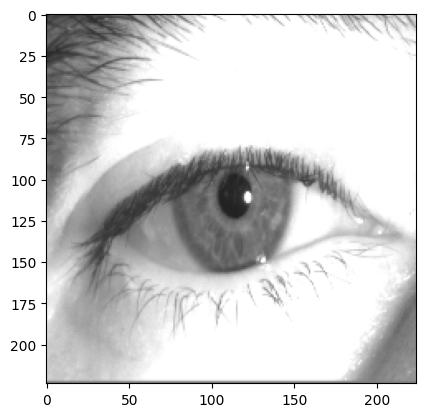

In [3]:
ri = random.randint(0, len(images) - 1)
print("Randome index: " + str(ri))
plt.imshow(images[ri])

Step 2: Split images and labels into 80-20 random train test split and train cnn

In [4]:
# Split the dataset into 70% train and 30% test
images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.3, random_state=42)

# Normalize the image data
images_train = images_train / 255.0
images_test = images_test / 255.0


labels_train_cnn = to_categorical(labels_train, num_classes=2)
labels_test_cnn = to_categorical(labels_test, num_classes=2)

In [7]:
class CapsuleLayer(layers.Layer):
    def __init__(self, num_capsules, capsule_dim, routing_iterations, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.capsule_dim = capsule_dim
        self.routing_iterations = routing_iterations

    def build(self, input_shape):
        self.W = self.add_weight(shape=[input_shape[-1], self.num_capsules * self.capsule_dim],
                                 initializer="glorot_uniform",
                                 trainable=True)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]

        # Shape inputs for transformation
        inputs_hat = tf.einsum('...ji,ik->...jk', inputs, self.W)
        inputs_hat = tf.reshape(inputs_hat, [batch_size, -1, self.num_capsules, self.capsule_dim])
        inputs_hat = tf.transpose(inputs_hat, perm=[0, 2, 1, 3])

        # Routing coefficients
        b = tf.zeros(shape=[batch_size, self.num_capsules, tf.shape(inputs_hat)[2]])

        for i in range(self.routing_iterations):
            c = tf.nn.softmax(b, axis=1)
            c = tf.expand_dims(c, -1)
            weighted_inputs = c * inputs_hat
            s = tf.reduce_sum(weighted_inputs, axis=2)
            v = self.squash(s)

            if i < self.routing_iterations - 1:
                b += tf.reduce_sum(inputs_hat * tf.expand_dims(v, 2), axis=-1)

        return v

    def squash(self, vector):
        norm = tf.reduce_sum(tf.square(vector), axis=-1, keepdims=True)
        scale = norm / (1 + norm)
        return scale * vector / tf.sqrt(norm + K.epsilon())


def create_capsnet_model(input_shape, num_classes, capsule_dim, routing_iterations):
    inputs = layers.Input(shape=input_shape)

    conv1 = layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
    conv2 = layers.Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu')(conv1)
    conv3 = layers.Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu')(conv2)

    reshaped = layers.Reshape((input_shape[0] * input_shape[1], 256))(conv3)

    caps_output = CapsuleLayer(num_capsules=num_classes, capsule_dim=capsule_dim, routing_iterations=routing_iterations)(reshaped)

    caps_output_flat = layers.Flatten()(caps_output)

    output = layers.Dense(num_classes, activation='softmax')(caps_output_flat)

    model = models.Model(inputs=inputs, outputs=output)
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

In [8]:
cnn_model = create_capsnet_model(input_shape, num_classes, capsule_dim, routing_iterations)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 224, 224, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 50176, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_layer_1 (CapsuleLayer)  │ (None, 2, 16)          │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 379,074 (1.45 MB)

 Trainable params: 379,074 (1.45 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
print(f"Train images count: {len(images_train)}")
print(f"Image Shape {images_train[0].shape}")
print(f"Test images count: {len(images_test)}")

Train images count: 1974
Image Shape (224, 224, 3)
Test images count: 846


In [10]:
cnn_model.fit(
    images_train,
    labels_train_cnn,
    epochs=10,
    validation_data=(images_test, labels_test_cnn)
)

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 555s 9s/step - accuracy: 0.7923 - loss: 0.5163 - val_accuracy: 0.8050 - val_loss: 0.4955
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 542s 9s/step - accuracy: 0.7971 - loss: 0.5061 - val_accuracy: 0.8050 - val_loss: 0.4987
Epoch 3/10
11/62 ━━━━━━━━━━━━━━━━━━━━ 7:18 9s/step - accuracy: 0.7944 - loss: 0.5111

KeyboardInterrupt: 

In [11]:
#Testing model
cnn_loss, cnn_accuracy = cnn_model.evaluate(images_test, labels_test_cnn)
print(f"CNN Test Accuracy: {cnn_accuracy * 100:.2f}%")

27/27 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.8255 - loss: 0.4665
CNN Test Accuracy: 80.50%


In [12]:
predictions = cnn_model.predict(images_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(labels_test_cnn, axis=1)

report = classification_report(true_classes, predicted_classes, target_names=['Fit for Duty', 'Alcoholic'])
print(report)

accuracy = accuracy_score(true_classes, predicted_classes)
print(f'Overall Accuracy: {accuracy * 100:.2f}%')

27/27 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step
              precision    recall  f1-score   support

Fit for Duty       0.00      0.00      0.00       165
   Alcoholic       0.80      1.00      0.89       681

    accuracy                           0.80       846
   macro avg       0.40      0.50      0.45       846
weighted avg       0.65      0.80      0.72       846

Overall Accuracy: 80.50%


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Demonstration

In [ ]:
totalTest = 0
correctTest = 0

(1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


Text(0.5, 1.0, 'Name: E_2_1_2_L_M_N_N_1980_9_2017.bmp\n\nPrediction: Fit for duty\nActual: Alcoholic\n\nAccuracy: 0.0')

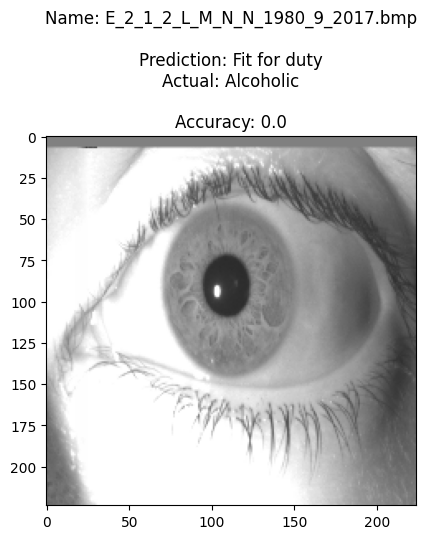

In [ ]:
# testImagePath = 'images/test2.png'
# testImg = cv2.imread(testImagePath, cv2.IMREAD_GRAYSCALE)

r_in = random.randint(0, len(images) - 1)

testImg = images[r_in]
testLabel = labels[r_in]
# testImg = cv2.resize(testImg, image_size)

plt.imshow(testImg, cmap='gray')

testImg = np.expand_dims(testImg, axis=0)

print(testImg.shape)

prediction = cnn_model.predict(testImg)
prediction = np.argmax(prediction[0])

totalTest +=1
correctTest += prediction==testLabel

prediction = 'Alcoholic' if prediction else 'Fit for duty'
testLabel = 'Alcoholic' if testLabel else 'Fit for duty'
plt.title(f'Name: {names[r_in]}\n\nPrediction: {prediction}\nActual: {testLabel}\n\nAccuracy: {correctTest/totalTest}')

In [ ]:
cnn_model.save("./Models/ResNet50Classification/NonAugmented.keras")